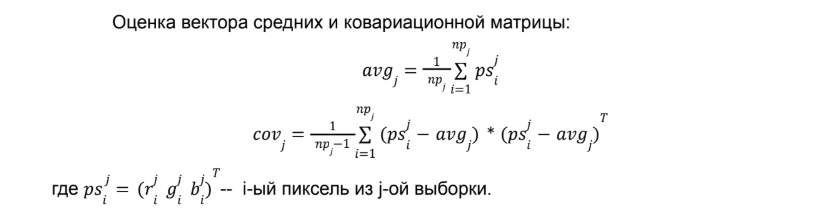

In [226]:
import numpy as np

def test(filename: str) -> None:
    with open(filename) as f:
        lines = [l.strip("\n") for l in f.readlines()]

    idx = 0
    num_classes = int(lines[idx])
    idx += 1

    class_points = [[] for _ in range(num_classes)]

    # СЧИТЫВАЕМ РАЗМЕТКУ ПИКСЕЛЕЙ ИСХОДНОГО ИЗОБРАЖЕНИЯ 
    for i in range(num_classes):
        line = lines[idx]
        numbers = [int(n) for n in line.split(" ")]
        num_pairs = numbers[0]
        for j in range(num_pairs):
            class_points[i].append(numbers[(j * 2 + 1):(j * 2 + 1) + 2])
        idx += 1

    width, height = [int(i[1]) for i in lines[idx].split(" ")]
    idx += 1

    # СОЗДАЕМ СЛОВАРЬ С ОТНОШЕНИЕМ КООРДИНАТЫ ПИКСЕЛЯ --> КЛАСС
    class_map = {}
    for i, points in enumerate(class_points):
        for p in points:
            class_map[tuple(p)] = i

    get_rgba_values = lambda x: [int(x[:2], 16), int(x[2:4], 16), int(x[4:6], 16), int(x[6:], 16)]
    channels = 4
    input_image = np.zeros((height, width, channels), dtype=np.uint8)

    for i in range(height):
        line = lines[idx]
        print_buffer = []
        for j, rgba in enumerate(line.split(" ")):
            rgba_vals = get_rgba_values(rgba)
            input_image[i, j] = np.array([*rgba_vals[:-1], 0])

        idx += 1

    # СЧИТАЕМ СРЕДНЕЕ ПО КОМПОНЕНТАМ (R, G, B) ВНУТРИ КАЖДОГО КЛАСТЕРА 
    sum_rgb_map = {}
    mean_rgb_map = {}
    for class_num, points in enumerate(class_points):
        mean_vector = np.zeros(3)
        for p in points:
            w, h = p
            mean_vector += np.array(input_image[h, w][:3])
        sum_rgb_map[class_num] = mean_vector
        mean_vector = mean_vector / len(points)
        mean_vector = mean_vector / np.sqrt(np.sum(mean_vector ** 2))
        mean_rgb_map[class_num] = mean_vector

    print("среднее нормированное значение RGB по всем классам:")
    for k, v in mean_rgb_map.items():
        print(f"класс {k}: {v}")
    print("\nсумма RGB по всем классам:")
    for k, v in sum_rgb_map.items():
        print(f"класс {k}: {v}")

    output_image = input_image.copy()
    height, width, _ = output_image.shape

    # ЦИКЛ ПО ВСЕМ ПИКСЕЛЯМ ИЗОБРАЖЕНИЯ
    for i in range(height):
        for j in range(width):
            # ЕСЛИ ПИКСЕЛЬ УЖЕ РАЗМЕЧЕН, ТО В ВЫХОДНОЕ ИЗОБРАЖЕНИЕ ВСТАВЛЯЕМ ЕГО РАЗМЕТКУ
            if (j, i) in class_map:
                output_image[i, j][-1] = class_map[(j, i)]
            else:
                max_cosine_sim = -100
                max_sim_cls = -1
                
                # МЕТОД СПЕКТРАЛЬНОГО УГЛА
                # ВЫЧИСЛЯЕМ КЛАСТЕР, СКАЛЯРНОЕ ПРОИЗВЕДЕНИЕ С ЦЕНТРАЛЬНЫМ ВЕКТОРОМ КОТОРОГО НА [R, G, B] ВЕКТОР ПИКСЕЛЯ НАИБОЛЬШЕЕ
                rgb = output_image[i, j][:3]
                for k, v in mean_rgb_map.items():
                    cosine_sim = np.sum(v * rgb)
                    if cosine_sim > max_cosine_sim:
                        max_cosine_sim = cosine_sim
                        max_sim_cls = k
                output_image[i, j][-1] = max_sim_cls

    print("\nклассы пикселей:")
    print(output_image[:, :, -1])

    return input_image, output_image

In [229]:
input_image_1, output_image_1 = test("example_1_input.txt")

среднее нормированное значение RGB по всем классам:
класс 0: [0.58693696 0.57798135 0.56695906]
класс 1: [0.57408196 0.77364797 0.26813935]

сумма RGB по всем классам:
класс 0: [852. 839. 823.]
класс 1: [653. 880. 305.]

классы пикселей:
[[1 0 1]
 [1 1 0]
 [1 0 0]]


In [232]:
print(output_image_1[:, :, -1])

[[1 0 1]
 [1 1 0]
 [1 0 0]]


In [235]:
input_image_2, output_image_2 = test("example_2_input.txt")

среднее нормированное значение RGB по всем классам:
класс 0: [0.70794761 0.10523546 0.69838075]
класс 1: [0.62411655 0.73626642 0.26151539]
класс 2: [0.64100006 0.68162682 0.35285097]
класс 3: [0.74032487 0.35853898 0.56865533]
класс 4: [0.65491347 0.57920093 0.48540151]

сумма RGB по всем классам:
класс 0: [518.  77. 511.]
класс 1: [1241. 1464.  520.]
класс 2: [852. 906. 469.]
класс 3: [828. 401. 636.]
класс 4: [1557. 1377. 1154.]

классы пикселей:
[[2 1 1 2 1 0 1 4]
 [2 0 4 2 4 4 0 1]
 [0 1 0 0 2 3 3 3]
 [3 0 4 4 2 0 1 2]
 [1 3 2 0 3 2 4 2]
 [3 4 2 2 3 1 1 1]
 [2 2 4 4 2 0 1 0]
 [4 3 3 4 4 0 3 4]]


In [241]:
print(output_image_2.shape)
print(output_image_2[:, :, -1])

(8, 8, 4)
[[2 1 1 2 1 0 1 4]
 [2 0 4 2 4 4 0 1]
 [0 1 0 0 2 3 3 3]
 [3 0 4 4 2 0 1 2]
 [1 3 2 0 3 2 4 2]
 [3 4 2 2 3 1 1 1]
 [2 2 4 4 2 0 1 0]
 [4 3 3 4 4 0 3 4]]


In [265]:
output_image_1[0, :, :3]

array([[162, 223,  76],
       [247, 201, 254],
       [158, 216,  69]], dtype=uint8)

In [264]:
# from PIL import Image
import struct
import ctypes

bin_filename = "test_example_1.bin"

h, w, _ = input_image_1.shape
pix = input_image_1
buff = ctypes.create_string_buffer(4 * w * h)
offset = 0
for i in range(h):
    for j in range(w):
        r = bytes((pix[i, j][0],))
        g = bytes((pix[i, j][1],))
        b = bytes((pix[i, j][2],))
        a = bytes((255,))
        print(i, j, f"[{pix[i, j][0]}, {pix[i, j][1]}, {pix[i, j][2]}]")
        struct.pack_into('cccc', buff, offset, r, g, b, a)
        offset += 4

out = open(bin_filename, 'wb')
out.write(struct.pack('ii', w, h))
out.write(buff.raw)
out.close()

0 0 [162, 223, 76]
0 1 [247, 201, 254]
0 2 [158, 216, 69]
1 0 [180, 232, 83]
1 1 [153, 209, 77]
1 2 [146, 221, 86]
2 0 [169, 224, 76]
2 1 [247, 209, 250]
2 2 [212, 208, 233]


# example 1

In [ ]:
# INPUT CLASSES
# 2
# 4 1 2 1 0 2 2 2 1
# 4 0 0 0 1 1 1 2 0

# INPUT IMAGE
# 03000000 03000000
# A2DF4C00 F7C9FE00 9ED84500
# B4E85300 99D14D00 92DD5600
# A9E04C00 F7D1FA00 D4D0E900

# OUTPUT IMAGE
# 03000000 03000000
# A2DF4C01 F7C9FE00 9ED84501
# B4E85301 99D14D01 92DD5601
# A9E04C01 F7D1FA00 D4D0E900

In [62]:
import numpy as np

class_map = [
    [[1, 2], [1, 0], [2, 2], [2, 1]],
    [[0, 0], [0, 1], [1, 1], [2, 0]]
]

# OUTPUT IMAGE
# 03000000 03000000
# A2DF4C01 F7C9FE00 9ED84501
# B4E85301 99D14D01 92DD5601
# A9E04C01 F7D1FA00 D4D0E900

input_image = np.array([
    ["A2DF4C00", "F7C9FE00", "9ED84500"],
    ["B4E85300", "99D14D00", "92DD5600"],
    ["A9E04C00", "F7D1FA00", "D4D0E900"]
])
height, width = input_image.shape

for class_num, points in enumerate(class_map):
    for p in points:
        w, h = p
        current_value = input_image[h, w]
        input_image[h, w] = current_value[:-2] + f"<{class_num}"

print(input_image, input_image.dtype)

# rgb = lambda x: [int(x[:2], 16), int(x[2:4], 16), int(x[4:6], 16)]

# for i in range(height):
#     for j in range(width):
#         rgb_arr = rgb(input_image[i, j])

[['A2DF4C<1' 'F7C9FE<0' '9ED845<1']
 ['B4E853<1' '99D14D<1' '92DD56<0']
 ['A9E04C00' 'F7D1FA<0' 'D4D0E9<0']] <U8


# example 2

**успех**

In [139]:
# INPUT DATA
# 5
# 4 5 0 0 2 6 1 1 1
# 6 2 0 7 1 1 0 1 2 6 0 4 0
# 4 3 0 3 1 0 1 0 0
# 4 0 3 6 2 5 2 7 2
# 9 6 4 5 1 7 0 2 1 2 3 4 1 1 5 3 3 2 6

# OUTPUT IMAGE
# 08000000 08000000
# D2E27502 CFF65201 D3ED5701 D6E76902 C8F35B01 8E168200 CFF45001 AE977604
# D3DC7102 7D1E7B00 AB9A8004 D9E58602 AB967E04 AE9D8004 87058200 D0F95B01
# 74148000 D0F55901 86136C00 85077400 D6E27702 D3609F03 D1609F03 CC5EA103
# CC739D03 7C127F00 AA988804 AFA07D04 D0E37702 7D117A00 D6EB5901 D6E37C02
# C9F85701 D655A103 D7EA7402 93127D00 D35BA403 D4DD7902 B0A18404 D6DE7502
# D765A903 AD928404 D0D87C02 D7E97F02 CD509E03 CAF85201 CFF75601 CEF45E01
# D0E86902 D1D17F02 AD928104 AFA18304 D4DB5C02 88077D00 C6F75701 7D127D00
# A99A8E04 C8609E03 D15DA503 AB957E04 AE9A8004 79218100 D065A103 A99E9A04

In [23]:
[1, 2, 3][:3]

[1, 2, 3]

In [50]:
a = np.zeros((2, 2))
a[0] = np.array([1, 1])
a

array([[1., 1.],
       [0., 0.]])

In [184]:
with open("example_2_input.txt") as f:
    lines = [l.strip("\n") for l in f.readlines()]

idx = 0
num_classes = int(lines[idx])
idx += 1

class_points = [[] for _ in range(num_classes)]

for i in range(num_classes):
    # print(idx, "# ", lines[idx])
    line = lines[idx]
    numbers = [int(n) for n in line.split(" ")]
    num_pairs = numbers[0]
    for j in range(num_pairs):
        class_points[i].append(numbers[(j * 2 + 1):(j * 2 + 1) + 2])
    idx += 1

# print(idx, "# ", lines[idx])
width, height = [int(i[1]) for i in lines[idx].split(" ")]
idx += 1

class_map = {}
for i, points in enumerate(class_points):
    for p in points:
        class_map[tuple(p)] = i

get_rgba_values = lambda x: [int(x[:2], 16), int(x[2:4], 16), int(x[4:6], 16), int(x[6:], 16)]
channels = 4
input_image = np.zeros((height, width, channels), dtype=np.uint8)
output_image = np.zeros((height, width, channels), dtype=np.uint8)
output_image_str = np.empty((height, width), dtype="S10")

for i in range(height):
    # print(idx, "# ", lines[idx])
    line = lines[idx]
    print_buffer = []
    for j, rgba in enumerate(line.split(" ")):
        rgba_vals = get_rgba_values(rgba)
        input_image[i, j] = np.array([*rgba_vals[:-1], 0])
        output_image[i, j] = np.array(rgba_vals)
        output_image_str[i, j] = rgba
        
        class_num = int(rgba[-1])
        if (j, i) in class_map:
            status = "+" if class_map[(j, i)] == class_num else "---"
            print_buffer.append(f"{rgba[:-2]}{status}{class_num}")
        else:
            print_buffer.append(f"{rgba}")
    print(" ".join(print_buffer))
    idx += 1
class_points

D2E275+2 CFF652+1 D3ED57+1 D6E769+2 C8F35B+1 8E1682+0 CFF450+1 AE9776+4
D3DC71+2 7D1E7B+0 AB9A80+4 D9E586+2 AB967E+4 AE9D80+4 870582+0 D0F95B+1
741480+0 D0F559+1 86136C00 85077400 D6E27702 D3609F+3 D1609F+3 CC5EA1+3
CC739D+3 7C127F00 AA9888+4 AFA07D+4 D0E37702 7D117A00 D6EB5901 D6E37C02
C9F85701 D655A103 D7EA7402 93127D00 D35BA403 D4DD7902 B0A184+4 D6DE7502
D765A903 AD9284+4 D0D87C02 D7E97F02 CD509E03 CAF85201 CFF75601 CEF45E01
D0E86902 D1D17F02 AD9281+4 AFA18304 D4DB5C02 88077D00 C6F75701 7D127D00
A99A8E04 C8609E03 D15DA503 AB957E04 AE9A8004 79218100 D065A103 A99E9A04


[[[5, 0], [0, 2], [6, 1], [1, 1]],
 [[2, 0], [7, 1], [1, 0], [1, 2], [6, 0], [4, 0]],
 [[3, 0], [3, 1], [0, 1], [0, 0]],
 [[0, 3], [6, 2], [5, 2], [7, 2]],
 [[6, 4], [5, 1], [7, 0], [2, 1], [2, 3], [4, 1], [1, 5], [3, 3], [2, 6]]]

In [185]:
output_image.shape

(8, 8, 4)

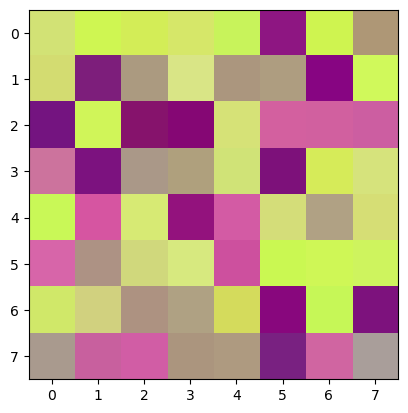

In [74]:
import matplotlib.pyplot as plt

plt.imshow(output_image[:, :, :-1])
plt.show()

In [186]:
# подсчет нормированных средних значений пикселей по классам
# [R_i_mean, G_i_mean, B_i_mean], R_i_mean - среднее значение R внутри класса i

mean_rgb_map = {}
for class_num, points in enumerate(class_points):
    mean_vector = np.zeros(3)
    for p in points:
        w, h = p
        mean_vector += np.array(input_image[h, w][:3])
    mean_vector = mean_vector / len(points)
    mean_vector = mean_vector / np.sqrt(np.sum(mean_vector ** 2))
    mean_rgb_map[class_num] = mean_vector

mean_rgb_map

{0: array([0.70794761, 0.10523546, 0.69838075]),
 1: array([0.62411655, 0.73626642, 0.26151539]),
 2: array([0.64100006, 0.68162682, 0.35285097]),
 3: array([0.74032487, 0.35853898, 0.56865533]),
 4: array([0.65491347, 0.57920093, 0.48540151])}

In [187]:
class_num = 0
print([output_image_str[p[1], p[0]] for p in class_points[class_num]])
print([input_image[p[1], p[0]][:3].tolist() for p in class_points[class_num]])
mv = np.mean([input_image[p[1], p[0]][:3] for p in class_points[class_num]], axis=0)
print(mv)
print(mv / np.sqrt(np.sum(mv ** 2)))
print(np.linalg.norm(mv), np.sqrt(np.sum(mv ** 2)))

[b'8E168200', b'74148000', b'87058200', b'7D1E7B00']
[[142, 22, 130], [116, 20, 128], [135, 5, 130], [125, 30, 123]]
[129.5   19.25 127.75]
[0.70794761 0.10523546 0.69838075]
182.92313959693564 182.92313959693564


In [188]:
input_image_copy = input_image.copy()
height, width, _ = input_image_copy.shape

for i in range(height):
    for j in range(width):
        if (j, i) in class_map:
            input_image_copy[i, j][-1] = class_map[(j, i)]
        else:
            max_cosine_sim = -100
            max_sim_cls = -1
            
            rgb = input_image_copy[i, j][:3]
            for k, v in mean_rgb_map.items():
                cosine_sim = np.sum(v * rgb)
                if cosine_sim > max_cosine_sim:
                    max_cosine_sim = cosine_sim
                    max_sim_cls = k
            print(f"[{i}, {j}]: class = {max_sim_cls}, rgb: {rgb}, {max_cosine_sim=}")
            input_image_copy[i, j][-1] = max_sim_cls

[2, 2]: class = 0, rgb: [134  19 108], max_cosine_sim=172.28957511577698
[2, 3]: class = 0, rgb: [133   7 116], max_cosine_sim=175.9058480567378
[2, 4]: class = 2, rgb: [214 226 119], max_cosine_sim=333.2109386394038
[3, 1]: class = 0, rgb: [124  18 127], max_cosine_sim=178.37409784183805
[3, 4]: class = 2, rgb: [208 227 119], max_cosine_sim=330.0465651244232
[3, 5]: class = 0, rgb: [125  17 122], max_cosine_sim=175.48490623292224
[3, 6]: class = 1, rgb: [214 235  89], max_cosine_sim=329.8584187257979
[3, 7]: class = 2, rgb: [214 227 124], max_cosine_sim=335.65682030778277
[4, 0]: class = 1, rgb: [201 248  87], max_cosine_sim=330.793336258831
[4, 1]: class = 3, rgb: [214  85 161], max_cosine_sim=280.4588439942562
[4, 2]: class = 2, rgb: [215 234 116], max_cosine_sim=338.246400345482
[4, 3]: class = 0, rgb: [147  18 125], max_cosine_sim=193.26013142949694
[4, 4]: class = 3, rgb: [211  91 164], max_cosine_sim=282.0950692495682
[4, 5]: class = 2, rgb: [212 221 121], max_cosine_sim=329.226

In [189]:
np.all(input_image_copy[:, :, :] == output_image[:, :, :])

True

In [ ]:
# D2E275+2 CFF652+1 D3ED57+1 D6E769+2 C8F35B+1 8E1682+0 CFF450+1 AE9776+4
# D3DC71+2 7D1E7B+0 AB9A80+4 D9E586+2 AB967E+4 AE9D80+4 870582+0 D0F95B+1
# 741480+0 D0F559+1 86136C00 85077400 D6E27702 D3609F+3 D1609F+3 CC5EA1+3
# CC739D+3 7C127F00 AA9888+4 AFA07D+4 D0E37702 7D117A00 D6EB5901 D6E37C02
# C9F85701 D655A103 D7EA7402 93127D00 D35BA403 D4DD7902 B0A184+4 D6DE7502
# D765A903 AD9284+4 D0D87C02 D7E97F02 CD509E03 CAF85201 CFF75601 CEF45E01
# D0E86902 D1D17F02 AD9281+4 AFA18304 D4DB5C02 88077D00 C6F75701 7D127D00
# A99A8E04 C8609E03 D15DA503 AB957E04 AE9A8004 79218100 D065A103 A99E9A04

In [136]:
input_image_copy[:, :, -1] == output_image[:, :, -1]

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

In [137]:
input_image_copy[:, :, -1]

array([[2, 1, 1, 2, 1, 0, 1, 4],
       [2, 0, 4, 2, 4, 4, 0, 1],
       [0, 1, 0, 0, 2, 3, 3, 3],
       [3, 0, 4, 4, 2, 0, 1, 2],
       [1, 3, 2, 0, 3, 2, 4, 2],
       [3, 4, 2, 2, 3, 1, 1, 1],
       [2, 2, 4, 4, 2, 0, 1, 0],
       [4, 3, 3, 4, 4, 0, 3, 4]], dtype=uint8)

In [202]:
output_image[:, :, -1]

array([[2, 1, 1, 2, 1, 0, 1, 4],
       [2, 0, 4, 2, 4, 4, 0, 1],
       [0, 1, 0, 0, 2, 3, 3, 3],
       [3, 0, 4, 4, 2, 0, 1, 2],
       [1, 3, 2, 0, 3, 2, 4, 2],
       [3, 4, 2, 2, 3, 1, 1, 1],
       [2, 2, 4, 4, 2, 0, 1, 0],
       [4, 3, 3, 4, 4, 0, 3, 4]], dtype=uint8)

**encode input_image to bytes**

In [155]:
input_image.shape

(8, 8, 4)

In [268]:
from PIL import Image
import struct
import ctypes

fname = "out_1_l"
bin_filename = f"{fname}.bin"
png_filename = f"{fname}.png"

fin = open(bin_filename, 'rb')
(w, h) = struct.unpack('ii', fin.read(8))
buff = ctypes.create_string_buffer(4 * w * h)
fin.readinto(buff)
fin.close()
img = Image.new('RGBA', (w, h))
pix = img.load()
offset = 0
for i in range(h):
    for j in range(w):
        (r, g, b, a) = struct.unpack_from('cccc', buff, offset)
        # print(r, g, b, a)
        pix[i, j] = (ord(r), ord(g), ord(b), ord(a))
        offset += 4

img.save(png_filename)
test_cuda_out_l = np.array(Image.open(png_filename))